In [1]:
import hcp_utils as hcp
import matplotlib.pyplot as plt
import nibabel as nb
import numpy as np
from nilearn import plotting

from src import timescale_utils


def cifti_to_volume(data, axis):
    """Convert CIFTI subcortex data to NIFTI"""
    assert isinstance(axis, nb.cifti2.BrainModelAxis)
    data = data.T[axis.volume_mask]
    vox_indices = tuple(axis.voxel[axis.volume_mask].T)  # ([x0, x1, ...], [y0, ...], [z0, ...])
    vol_data = np.zeros(axis.volume_shape + data.shape[1:], dtype=data.dtype)
    vol_data[vox_indices] = data
    return nb.Nifti1Image(vol_data, axis.affine)


dtseries = "./data/hcp7T.dtseries.nii"
cifti = nb.cifti2.load(dtseries)
axis = cifti.header.get_axis(1)

X = cifti.get_fdata(dtype=np.float32)
X = (X - X.mean(axis=0)) / X.std(axis=0)

ols = timescale_utils.OLS(var_estimator="newey-west", cov_n_lags=100, n_jobs=-1)
estimates_ = ols.fit(X, X.shape[0])

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


/var/folders/kk/_kp50ntn3xb5_kv9_m3q3sw80000gn/T/ipykernel_34536/96937816.py:15: RuntimeWarning: Mean of empty slice.
  ].mean()
/usr/local/Caskroom/miniconda/base/envs/fmri-timescales/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


<BarContainer object of 25 artists>

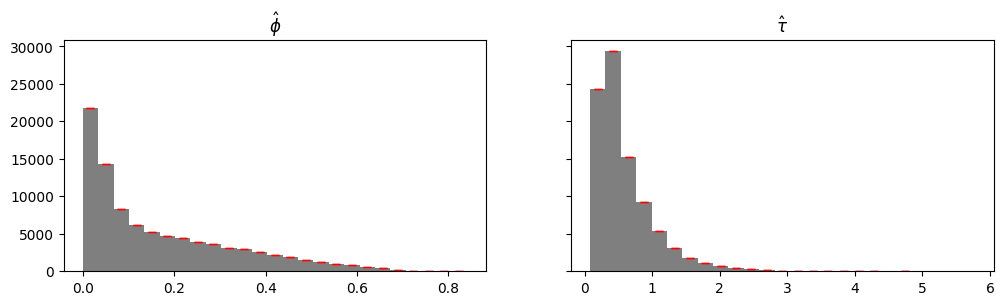

In [2]:
# histogram and bin edges for "phi" and "tau"
n_phi, bins_phi = np.histogram(estimates_["phi"], bins=25)
n_tau, bins_tau = np.histogram(estimates_["tau"], bins=25)

# standard errors for each bin for "phi" and "tau"
se_phi = [
    estimates_["se(phi)"][
        (estimates_["phi"] >= bins_phi[i]) & (estimates_["phi"] < bins_phi[i + 1])
    ].mean()
    for i in range(len(bins_phi) - 1)
]
se_tau = [
    estimates_["se(tau)"][
        (estimates_["tau"] >= bins_tau[i]) & (estimates_["tau"] < bins_tau[i + 1])
    ].mean()
    for i in range(len(bins_tau) - 1)
]

fig, axs = plt.subplots(ncols=2, figsize=(12, 3), sharey=True)
bar_kwargs = dict(color="k", alpha=0.5, ecolor="r", capsize=3)

axs[0].set_title(r"$\hat\phi$")
axs[0].bar(
    (bins_phi[:-1] + bins_phi[1:]) / 2, n_phi, width=np.diff(bins_phi), yerr=se_phi, **bar_kwargs
)
axs[1].set_title(r"$\hat\tau$")
axs[1].bar(
    (bins_tau[:-1] + bins_tau[1:]) / 2, n_tau, width=np.diff(bins_tau), yerr=se_tau, **bar_kwargs
)

(-52.0, 28.0)

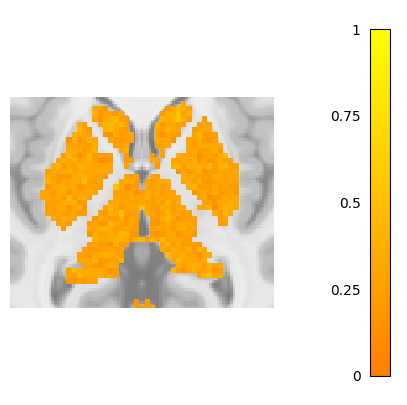

In [3]:
img = cifti_to_volume(estimates_["tau"], axis)

fig, ax = plt.subplots(figsize=(5, 5))

plot = plotting.plot_stat_map(
    img,
    axes=ax,
    display_mode="z",
    cut_coords=[0],
    black_bg=False,
    annotate=False,
    colorbar=True,
    cmap="autumn",
    vmax=1,
)

plot.axes[0].ax.set_xlim(-50, 50)
plot.axes[0].ax.set_ylim(-52, 28)

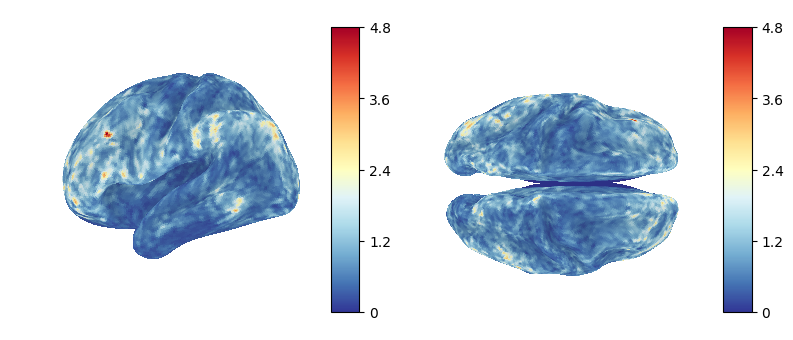

In [4]:
# !! 30-sec runtime !!

fig, axs = plt.subplots(ncols=2, figsize=(8, 6), subplot_kw=dict(projection="3d"))
fig.tight_layout()

kwargs = dict(bg_map=hcp.mesh.sulc, bg_on_data=True, darkness=0.25, cmap="RdYlBu_r", colorbar=True)

plotting.plot_surf(
    hcp.mesh.inflated,
    hcp.cortex_data(estimates_["tau"]),
    axes=axs[0],
    view="lateral",
    **kwargs,
)
plotting.plot_surf(
    hcp.mesh.inflated,
    hcp.cortex_data(estimates_["tau"]),
    axes=axs[1],
    view="dorsal",
    **kwargs,
)
pass